In [1]:
import tensorflow as tf
keras, L = tf.keras, tf.keras.layers


import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

In [2]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

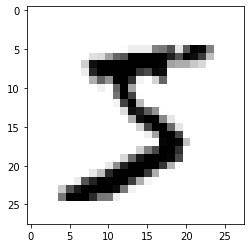

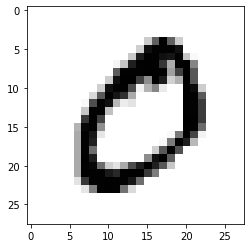

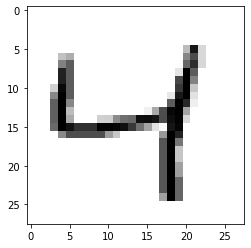

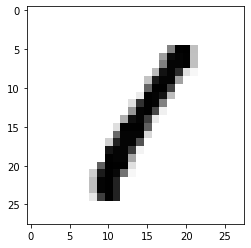

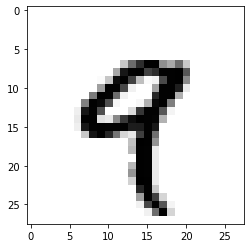

In [4]:
for i in range(5):
    plt.imshow(np.reshape(X[i], (28, 28)), cmap=plt.cm.gray_r)
    plt.show()

In [4]:
train_samples = 5000
test_samples = 1000
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=train_samples, test_size=test_samples, random_state=42)
del X, y

In [6]:
X_train = np.reshape(X_train, (X_train.shape[0], 28, 28, 1)) / 255.
y_train = y_train.astype(int)

X_test = np.reshape(X_test, (X_test.shape[0], 28, 28, 1)) / 255.
y_test = y_test.astype(int)

In [7]:
X_train.shape

(5000, 28, 28, 1)

In [10]:
model = keras.models.Sequential()
model.add(L.InputLayer([28, 28, 1]))
model.add(L.Conv2D(32, kernel_size=(3,3)))
model.add(L.BatchNormalization())
model.add(L.Activation("relu"))

model.add(L.Conv2D(64, kernel_size=(3,3)))
model.add(L.BatchNormalization())
model.add(L.Activation("relu"))

model.add(L.Flatten())

model.add(L.Dense(100, activation='relu'))
model.add(L.Dense(10, activation='softmax'))

In [11]:
adam = keras.optimizers.Adam()
model.compile(optimizer=adam, 
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

checkpointer = keras.callbacks.ModelCheckpoint(filepath="my_mnist.hdf5", 
                                               monitor="val_sparse_categorical_accuracy",
                                               verbose=1, save_best_only=True)
earlystopper = keras.callbacks.EarlyStopping(monitor="val_sparse_categorical_accuracy", patience=4, 
                                             verbose=1)

model.fit(X_train, y_train,
          batch_size=32, epochs=20, 
          validation_data=(X_test, y_test), 
          callbacks=[earlystopper, checkpointer])

Train on 5000 samples, validate on 1000 samples
Epoch 1/20
4992/5000 [============================>.] - ETA: 0s - loss: 0.9251 - sparse_categorical_accuracy: 0.8251
Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.43800, saving model to my_mnist.hdf5
5000/5000 [==============================] - 15s 3ms/sample - loss: 0.9248 - sparse_categorical_accuracy: 0.8250 - val_loss: 1.6081 - val_sparse_categorical_accuracy: 0.4380
Epoch 2/20
4992/5000 [============================>.] - ETA: 0s - loss: 0.1336 - sparse_categorical_accuracy: 0.9585
Epoch 00002: val_sparse_categorical_accuracy improved from 0.43800 to 0.84500, saving model to my_mnist.hdf5
5000/5000 [==============================] - 14s 3ms/sample - loss: 0.1338 - sparse_categorical_accuracy: 0.9584 - val_loss: 0.5475 - val_sparse_categorical_accuracy: 0.8450
Epoch 3/20
4992/5000 [============================>.] - ETA: 0s - loss: 0.0938 - sparse_categorical_accuracy: 0.9714
Epoch 00003: val_sparse_categorical_ac

In [12]:
model.load_weights("my_mnist.hdf5")

In [22]:
def choose_images():
    att_i, ch_i = np.random.randint(len(X_test), size=2)

    attacked_img = X_test[att_i]
    changed_img = X_test[ch_i]

    attacked_img = tf.cast(tf.reshape(attacked_img, [1, *attacked_img.shape]), tf.float32)
    changed_img = tf.cast(tf.reshape(changed_img, [1, *changed_img.shape]), tf.float32)

    print("Attacked image: ")
    print("Logits: ", model(attacked_img).numpy()[0])
    print("Predicted: ", np.argmax(model(attacked_img)[0]))
    print("Real: ", y_test[att_i])
    plt.imshow(attacked_img[0, :, :, 0], cmap=plt.cm.gray_r)
    plt.show()

    print("Changing image: ")
    print("Logits: ", model(changed_img).numpy()[0])
    print("Predicted: ", np.argmax(model(changed_img)[0]))
    print("Real: ", y_test[ch_i])
    plt.imshow(changed_img[0, :, :, 0], cmap=plt.cm.gray_r)
    plt.show()
    
    return att_i, attacked_img, ch_i, changed_img

In [23]:
def attack(attacked_img, changed_img, eps=1, fn=tf.identity, iterations=40):  
    y = model(attacked_img)

    for i in range(iterations):
        with tf.GradientTape() as tape:
            tape.watch(changed_img)
            y_pred = model(changed_img)
            loss = tf.reduce_mean((y - y_pred) ** 2)

        gradients, = tape.gradient(loss, changed_img)
        
        changed_img = tf.clip_by_value(changed_img - eps * fn(gradients), 0, 1)
        if i % 10 == 0:
            print("Loss : ", loss.numpy())
            print("Predict of changing image: ", np.argmax(y_pred[0]))
            print("Logits of changing image: ", y_pred.numpy()[0])
            print("Logits of attacked image: ", y.numpy()[0])
            plt.imshow(changed_img[0, :, :, 0], cmap=plt.cm.gray_r)
            plt.show()


Attacked image: 
Logits:  [4.5782681e-18 2.3228424e-13 4.6561536e-06 5.3788826e-06 5.0701245e-15
 1.0942907e-05 1.1883985e-13 6.0125106e-11 9.9997902e-01 9.4249208e-10]
Predicted:  8
Real:  8


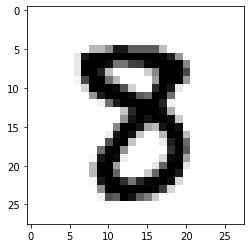

Changing image: 
Logits:  [9.9985242e-01 8.7491420e-12 4.1026722e-13 2.2073492e-09 3.6288056e-11
 1.5565578e-05 5.5375365e-10 6.6487733e-13 9.1384003e-08 1.3185044e-04]
Predicted:  0
Real:  0


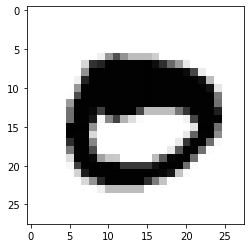

In [24]:
att_i, attacked_img, ch_i, changed_img = choose_images()

Loss :  0.19996627
Predict of changing image:  0
Logits of changing image:  [9.9985242e-01 8.7491420e-12 4.1026722e-13 2.2073492e-09 3.6288056e-11
 1.5565578e-05 5.5375365e-10 6.6487733e-13 9.1384003e-08 1.3185044e-04]
Logits of attacked image:  [4.5782681e-18 2.3228424e-13 4.6561536e-06 5.3788826e-06 5.0701245e-15
 1.0942907e-05 1.1883985e-13 6.0125106e-11 9.9997902e-01 9.4249208e-10]


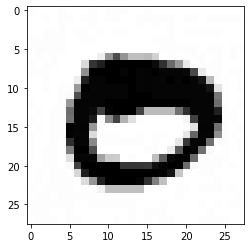

Loss :  0.13386829
Predict of changing image:  5
Logits of changing image:  [3.5852256e-01 1.9092324e-08 2.3200970e-09 2.2962874e-04 5.6455969e-09
 4.0621549e-01 3.1943732e-06 3.2772871e-10 4.0840884e-03 2.3094505e-01]
Logits of attacked image:  [4.5782681e-18 2.3228424e-13 4.6561536e-06 5.3788826e-06 5.0701245e-15
 1.0942907e-05 1.1883985e-13 6.0125106e-11 9.9997902e-01 9.4249208e-10]


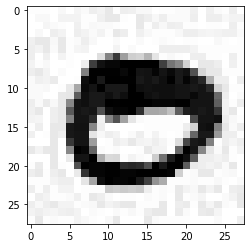

Loss :  0.13010922
Predict of changing image:  0
Logits of changing image:  [4.9240756e-01 2.6255944e-07 1.8828756e-09 3.2956310e-04 1.4221700e-08
 9.0065248e-02 1.7803603e-07 5.1267355e-09 4.4999458e-02 3.7219775e-01]
Logits of attacked image:  [4.5782681e-18 2.3228424e-13 4.6561536e-06 5.3788826e-06 5.0701245e-15
 1.0942907e-05 1.1883985e-13 6.0125106e-11 9.9997902e-01 9.4249208e-10]


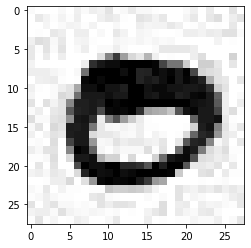

Loss :  1.1743964e-10
Predict of changing image:  8
Logits of changing image:  [2.9288742e-06 1.2164752e-07 9.2518819e-11 1.0670378e-07 3.8846965e-10
 2.6818319e-05 1.4956527e-12 4.0770329e-10 9.9995422e-01 1.5795926e-05]
Logits of attacked image:  [4.5782681e-18 2.3228424e-13 4.6561536e-06 5.3788826e-06 5.0701245e-15
 1.0942907e-05 1.1883985e-13 6.0125106e-11 9.9997902e-01 9.4249208e-10]


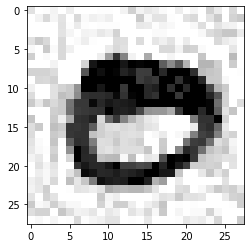

In [31]:
attack(attacked_img, changed_img, eps=0.01, fn=tf.sign, iterations=40)

Attacked image: 
Logits:  [5.1855238e-08 9.3156250e-06 1.6368260e-07 2.8802644e-06 1.4549907e-01
 1.3260922e-07 5.8759964e-10 3.9511785e-02 8.7365939e-04 8.1410295e-01]
Predicted:  9
Real:  9


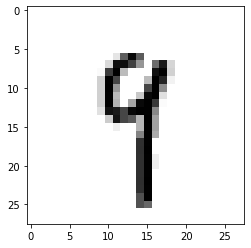

Changing image: 
Logits:  [1.4698426e-08 3.1247158e-09 5.2904780e-04 2.3555585e-04 2.6497631e-09
 1.3099645e-10 9.2646689e-12 9.9762517e-01 2.0538328e-05 1.5896466e-03]
Predicted:  7
Real:  7


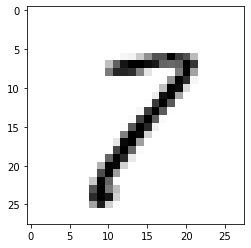

In [32]:
att_i, attacked_img, ch_i, changed_img = choose_images()

Loss :  0.159933
Predict of changing image:  7
Logits of changing image:  [1.4698426e-08 3.1247158e-09 5.2904780e-04 2.3555585e-04 2.6497631e-09
 1.3099645e-10 9.2646689e-12 9.9762517e-01 2.0538328e-05 1.5896466e-03]
Logits of attacked image:  [5.1855238e-08 9.3156250e-06 1.6368260e-07 2.8802644e-06 1.4549907e-01
 1.3260922e-07 5.8759964e-10 3.9511785e-02 8.7365939e-04 8.1410295e-01]


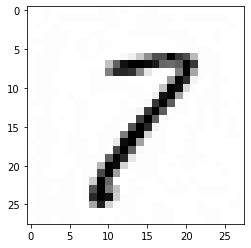

Loss :  0.00271407
Predict of changing image:  9
Logits of changing image:  [3.5298978e-08 2.2247591e-06 4.8020647e-05 4.1609231e-02 8.9714192e-09
 5.2754348e-07 8.3613216e-10 6.7919277e-02 2.1467634e-02 8.6895311e-01]
Logits of attacked image:  [5.1855238e-08 9.3156250e-06 1.6368260e-07 2.8802644e-06 1.4549907e-01
 1.3260922e-07 5.8759964e-10 3.9511785e-02 8.7365939e-04 8.1410295e-01]


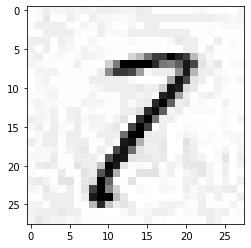

Loss :  0.0030959784
Predict of changing image:  9
Logits of changing image:  [2.3885056e-08 2.6480793e-06 2.5858179e-05 2.3902310e-02 9.5552295e-09
 6.9423095e-07 7.2711870e-10 4.1856591e-02 2.8052025e-02 9.0615982e-01]
Logits of attacked image:  [5.1855238e-08 9.3156250e-06 1.6368260e-07 2.8802644e-06 1.4549907e-01
 1.3260922e-07 5.8759964e-10 3.9511785e-02 8.7365939e-04 8.1410295e-01]


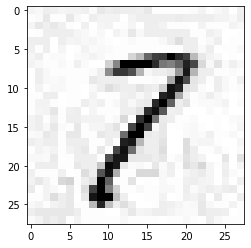

Loss :  0.003059412
Predict of changing image:  9
Logits of changing image:  [2.2627983e-08 2.3114412e-06 2.7962396e-05 2.1489454e-02 1.0294941e-08
 6.9908225e-07 7.8523166e-10 4.6998646e-02 2.6569890e-02 9.0491110e-01]
Logits of attacked image:  [5.1855238e-08 9.3156250e-06 1.6368260e-07 2.8802644e-06 1.4549907e-01
 1.3260922e-07 5.8759964e-10 3.9511785e-02 8.7365939e-04 8.1410295e-01]


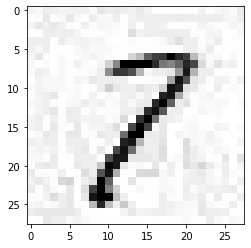

In [37]:
attack(attacked_img, changed_img, eps=0.01, fn=tf.sign)

Attacked image: 
Logits:  [1.6075830e-09 1.4258504e-14 6.2135491e-14 3.7605663e-10 6.3869841e-08
 3.8864385e-12 8.3860613e-11 7.4535626e-07 4.4048868e-08 9.9999917e-01]
Predicted:  9
Real:  9


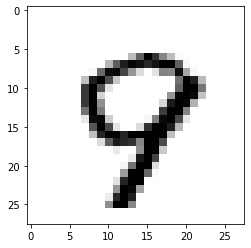

Changing image: 
Logits:  [1.2208775e-09 2.3213922e-09 2.6425928e-08 9.9797934e-01 1.0272205e-11
 5.6536296e-06 1.2744781e-09 6.4426384e-09 1.9189974e-04 1.8230259e-03]
Predicted:  3
Real:  3


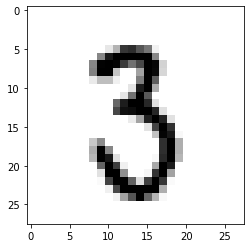

In [40]:
att_i, attacked_img, ch_i, changed_img = choose_images()

Loss :  0.19923185
Predict of changing image:  3
Logits of changing image:  [1.2208775e-09 2.3213922e-09 2.6425928e-08 9.9797934e-01 1.0272205e-11
 5.6536296e-06 1.2744781e-09 6.4426384e-09 1.9189974e-04 1.8230259e-03]
Logits of attacked image:  [1.6075830e-09 1.4258504e-14 6.2135491e-14 3.7605663e-10 6.3869841e-08
 3.8864385e-12 8.3860613e-11 7.4535626e-07 4.4048868e-08 9.9999917e-01]


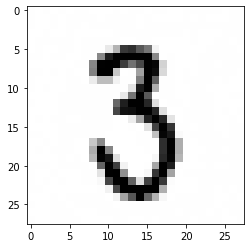

Loss :  0.0723599
Predict of changing image:  3
Logits of changing image:  [1.1283530e-05 1.5656218e-07 4.2099080e-07 5.9764206e-01 1.6123687e-08
 1.9081331e-04 3.1635977e-08 9.1531174e-06 7.4301255e-03 3.9471602e-01]
Logits of attacked image:  [1.6075830e-09 1.4258504e-14 6.2135491e-14 3.7605663e-10 6.3869841e-08
 3.8864385e-12 8.3860613e-11 7.4535626e-07 4.4048868e-08 9.9999917e-01]


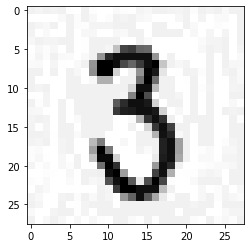

Loss :  2.3565178e-06
Predict of changing image:  9
Logits of changing image:  [8.0047041e-04 4.1614339e-08 2.8930172e-08 2.3832927e-03 1.2275797e-07
 1.0395904e-05 2.0942641e-09 1.6598254e-04 7.2582136e-04 9.9591380e-01]
Logits of attacked image:  [1.6075830e-09 1.4258504e-14 6.2135491e-14 3.7605663e-10 6.3869841e-08
 3.8864385e-12 8.3860613e-11 7.4535626e-07 4.4048868e-08 9.9999917e-01]


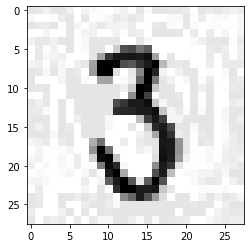

Loss :  1.9164887e-09
Predict of changing image:  9
Logits of changing image:  [2.9421497e-05 1.3184541e-10 1.3429614e-10 5.5023131e-05 5.4474323e-09
 1.1985642e-07 3.2970311e-11 2.3029088e-05 1.3919657e-05 9.9987841e-01]
Logits of attacked image:  [1.6075830e-09 1.4258504e-14 6.2135491e-14 3.7605663e-10 6.3869841e-08
 3.8864385e-12 8.3860613e-11 7.4535626e-07 4.4048868e-08 9.9999917e-01]


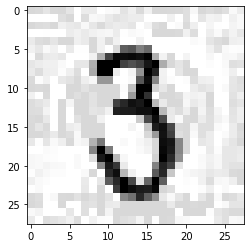

In [44]:
attack(attacked_img, changed_img, eps=0.005, fn=tf.sign)

Attacked image: 
Logits:  [2.7295850e-09 6.3906617e-14 4.8222002e-08 1.3597288e-11 6.7237238e-10
 1.9392908e-16 2.1307557e-16 9.9999988e-01 1.8481822e-11 1.5576620e-07]
Predicted:  7
Real:  7


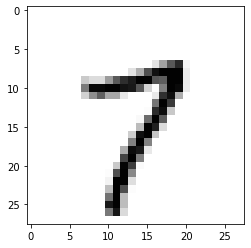

Changing image: 
Logits:  [2.5861549e-15 1.8762491e-14 1.2246360e-16 7.6429696e-12 6.4160101e-12
 3.9913415e-13 7.6407819e-16 2.1381359e-07 6.1561162e-10 9.9999976e-01]
Predicted:  9
Real:  9


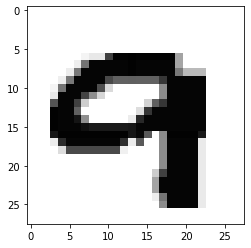

In [51]:
att_i, attacked_img, ch_i, changed_img = choose_images()

Loss :  0.19999984
Predict of changing image:  9
Logits of changing image:  [2.5861549e-15 1.8762491e-14 1.2246360e-16 7.6429696e-12 6.4160101e-12
 3.9913415e-13 7.6407819e-16 2.1381359e-07 6.1561162e-10 9.9999976e-01]
Logits of attacked image:  [2.7295850e-09 6.3906617e-14 4.8222002e-08 1.3597288e-11 6.7237238e-10
 1.9392908e-16 2.1307557e-16 9.9999988e-01 1.8481822e-11 1.5576620e-07]


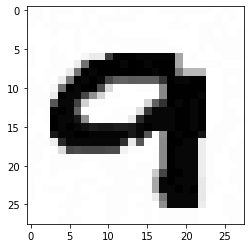

Loss :  0.015882323
Predict of changing image:  7
Logits of changing image:  [3.98787492e-09 9.94192922e-11 1.13762766e-07 1.09157376e-07
 5.79613229e-08 4.28801282e-13 6.37819536e-14 7.18199074e-01
 1.97765093e-08 2.81800658e-01]
Logits of attacked image:  [2.7295850e-09 6.3906617e-14 4.8222002e-08 1.3597288e-11 6.7237238e-10
 1.9392908e-16 2.1307557e-16 9.9999988e-01 1.8481822e-11 1.5576620e-07]


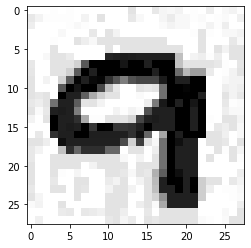

Loss :  1.2988541e-13
Predict of changing image:  7
Logits of changing image:  [1.0928167e-09 1.8704207e-13 3.4475025e-07 4.3437400e-11 2.2021875e-10
 2.5589740e-19 5.6161784e-19 9.9999893e-01 2.3273324e-13 7.0479047e-07]
Logits of attacked image:  [2.7295850e-09 6.3906617e-14 4.8222002e-08 1.3597288e-11 6.7237238e-10
 1.9392908e-16 2.1307557e-16 9.9999988e-01 1.8481822e-11 1.5576620e-07]


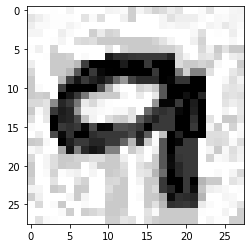

Loss :  2.7008327e-15
Predict of changing image:  7
Logits of changing image:  [3.1703792e-10 5.0827411e-15 1.6363023e-08 3.1057939e-13 2.2359168e-11
 1.5264836e-21 3.0544304e-21 1.0000000e+00 2.3862527e-15 4.7247841e-08]
Logits of attacked image:  [2.7295850e-09 6.3906617e-14 4.8222002e-08 1.3597288e-11 6.7237238e-10
 1.9392908e-16 2.1307557e-16 9.9999988e-01 1.8481822e-11 1.5576620e-07]


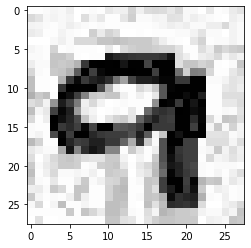

In [52]:
attack(attacked_img, changed_img, eps=0.01, fn=tf.sign)

Attacked image: 
Logits:  [4.1559640e-13 2.9751486e-11 4.5547521e-10 2.4322120e-16 1.0000000e+00
 6.2764439e-11 4.5957075e-13 5.8844869e-08 1.8263124e-11 4.5549566e-08]
Predicted:  4
Real:  4


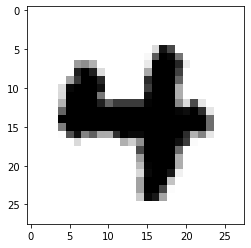

Changing image: 
Logits:  [1.4901248e-17 1.8312793e-15 3.4970840e-09 5.1271529e-18 7.0623063e-10
 9.9364058e-19 1.0000000e+00 1.6331403e-16 1.4098542e-16 5.5938479e-13]
Predicted:  6
Real:  6


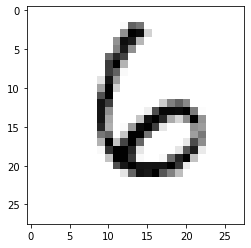

In [59]:
att_i, attacked_img, ch_i, changed_img = choose_images()

Loss :  0.2
Predict of changing image:  6
Logits of changing image:  [1.4901248e-17 1.8312793e-15 3.4970840e-09 5.1271529e-18 7.0623063e-10
 9.9364058e-19 1.0000000e+00 1.6331403e-16 1.4098542e-16 5.5938479e-13]
Logits of attacked image:  [4.1559640e-13 2.9751486e-11 4.5547521e-10 2.4322120e-16 1.0000000e+00
 6.2764439e-11 4.5957075e-13 5.8844869e-08 1.8263124e-11 4.5549566e-08]


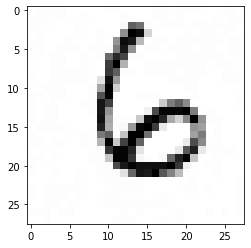

Loss :  0.19994259
Predict of changing image:  6
Logits of changing image:  [6.95130378e-15 8.62236338e-10 1.42825505e-04 1.81286481e-15
 7.21567267e-05 1.69139456e-15 9.99785125e-01 7.86598217e-13
 1.23288046e-11 1.39058175e-11]
Logits of attacked image:  [4.1559640e-13 2.9751486e-11 4.5547521e-10 2.4322120e-16 1.0000000e+00
 6.2764439e-11 4.5957075e-13 5.8844869e-08 1.8263124e-11 4.5549566e-08]


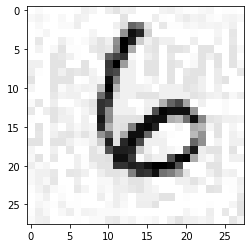

Loss :  8.222134e-08
Predict of changing image:  4
Logits of changing image:  [1.9782838e-10 6.6248199e-06 4.8231633e-04 1.1255565e-15 9.9927074e-01
 1.1895919e-14 2.4024284e-04 4.4173085e-10 4.5343153e-11 3.3508255e-11]
Logits of attacked image:  [4.1559640e-13 2.9751486e-11 4.5547521e-10 2.4322120e-16 1.0000000e+00
 6.2764439e-11 4.5957075e-13 5.8844869e-08 1.8263124e-11 4.5549566e-08]


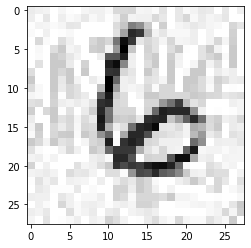

Loss :  9.017881e-15
Predict of changing image:  4
Logits of changing image:  [1.5445111e-15 4.2565670e-08 6.6475003e-08 2.7672704e-20 9.9999976e-01
 3.2870366e-16 1.4707196e-07 9.8756596e-15 1.1996319e-14 6.4898966e-15]
Logits of attacked image:  [4.1559640e-13 2.9751486e-11 4.5547521e-10 2.4322120e-16 1.0000000e+00
 6.2764439e-11 4.5957075e-13 5.8844869e-08 1.8263124e-11 4.5549566e-08]


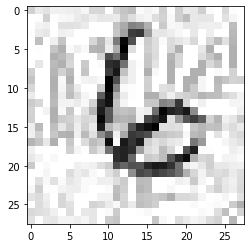

In [60]:
attack(attacked_img, changed_img, eps=0.01, fn=tf.sign)

Attacked image: 
Logits:  [5.8609107e-06 8.6676155e-06 1.9835253e-04 1.2628999e-05 8.1040816e-05
 2.7856810e-08 8.1865133e-11 9.9782073e-01 1.7265334e-05 1.8554276e-03]
Predicted:  7
Real:  7


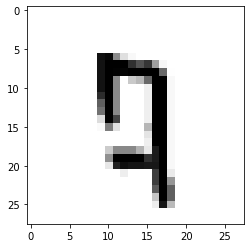

Changing image: 
Logits:  [2.4154684e-10 9.9999940e-01 6.1195017e-08 6.1052426e-12 5.0778897e-07
 1.1490703e-12 2.3512006e-12 1.1995985e-08 1.8033247e-10 2.3110541e-10]
Predicted:  1
Real:  1


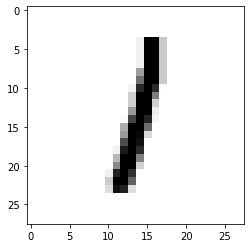

In [80]:
att_i, attacked_img, ch_i, changed_img = choose_images()

Loss :  0.19956312
Predict of changing image:  1
Logits of changing image:  [2.4154684e-10 9.9999940e-01 6.1195017e-08 6.1052426e-12 5.0778897e-07
 1.1490703e-12 2.3512006e-12 1.1995985e-08 1.8033247e-10 2.3110541e-10]
Logits of attacked image:  [5.8609107e-06 8.6676155e-06 1.9835253e-04 1.2628999e-05 8.1040816e-05
 2.7856810e-08 8.1865133e-11 9.9782073e-01 1.7265334e-05 1.8554276e-03]


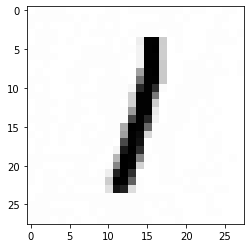

Loss :  0.1878697
Predict of changing image:  1
Logits of changing image:  [8.8767574e-06 9.4862032e-01 1.1727410e-02 1.8393312e-09 3.0639686e-02
 3.5062675e-11 7.6362632e-08 9.0019284e-03 1.0462404e-06 5.8837833e-07]
Logits of attacked image:  [5.8609107e-06 8.6676155e-06 1.9835253e-04 1.2628999e-05 8.1040816e-05
 2.7856810e-08 8.1865133e-11 9.9782073e-01 1.7265334e-05 1.8554276e-03]


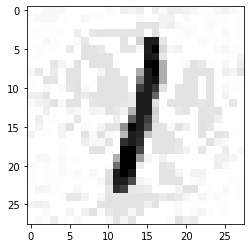

Loss :  8.748906e-06
Predict of changing image:  7
Logits of changing image:  [2.9804645e-04 4.4222479e-03 1.8677739e-03 4.1841370e-09 2.9131651e-03
 5.4449288e-12 3.1598751e-10 9.9049360e-01 1.3556100e-06 3.7457662e-06]
Logits of attacked image:  [5.8609107e-06 8.6676155e-06 1.9835253e-04 1.2628999e-05 8.1040816e-05
 2.7856810e-08 8.1865133e-11 9.9782073e-01 1.7265334e-05 1.8554276e-03]


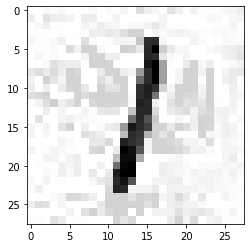

Loss :  9.381814e-06
Predict of changing image:  7
Logits of changing image:  [3.9995607e-04 1.9908994e-03 3.2936283e-03 3.0363740e-09 4.2128121e-03
 1.1150878e-11 1.0888737e-09 9.9009728e-01 1.8155529e-06 3.6066212e-06]
Logits of attacked image:  [5.8609107e-06 8.6676155e-06 1.9835253e-04 1.2628999e-05 8.1040816e-05
 2.7856810e-08 8.1865133e-11 9.9782073e-01 1.7265334e-05 1.8554276e-03]


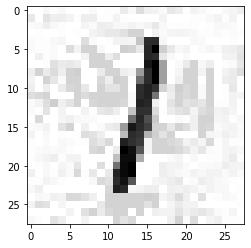

In [81]:
attack(attacked_img, changed_img, eps=0.01, fn=tf.sign)